In [1]:
import matplotlib.pyplot as pp
import pycbc.noise
import pycbc.psd
import pycbc.filter
from pycbc.waveform import get_td_waveform
import numpy as np


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


# Generating noise and colouring it with provided PSD

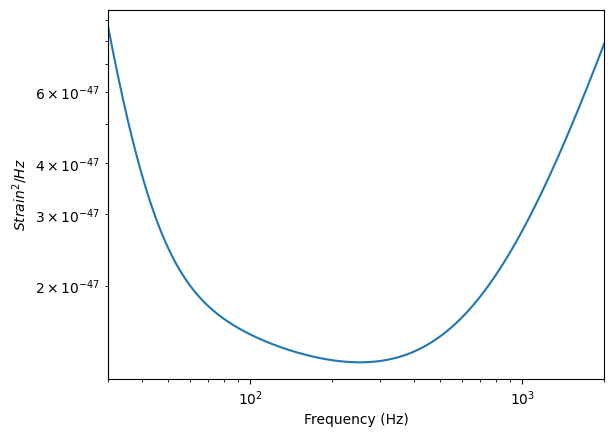

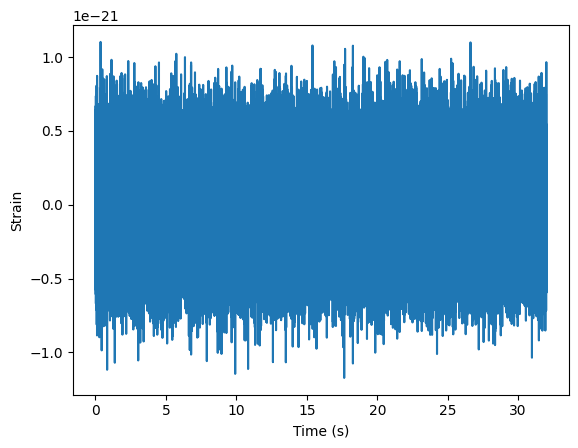

In [2]:
def gen_noise(psd_need):
    
    # The color of the noise matches a PSD which you provide
    flow = 30.0
    delta_f = 1.0 / 16
    flen = int(2048 / delta_f) + 1
    psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

    if (psd_need == True) :
        pp.plot(psd.sample_frequencies,psd.data)
        pp.loglog()
        pp.xlim(30,2000)
        pp.ylabel('$Strain^2 / Hz$')
        pp.xlabel('Frequency (Hz)')
        pp.show()


    # Generate 32 seconds of noise at 4096 Hz
    delta_t = 1.0 / 4096
    tsamples = int(32/ delta_t)
    ts = pycbc.noise.gaussian.noise_from_psd(tsamples,delta_t, psd, seed=127)
    
    #plotting noise 
    pp.plot(ts.sample_times, ts)
    pp.ylabel('Strain')
    pp.xlabel('Time (s)')
    pp.show()
    
    return ts

noise = gen_noise(True)

# Generating Strain

fp=0.5494252193754385, fc=-0.5320202660769405


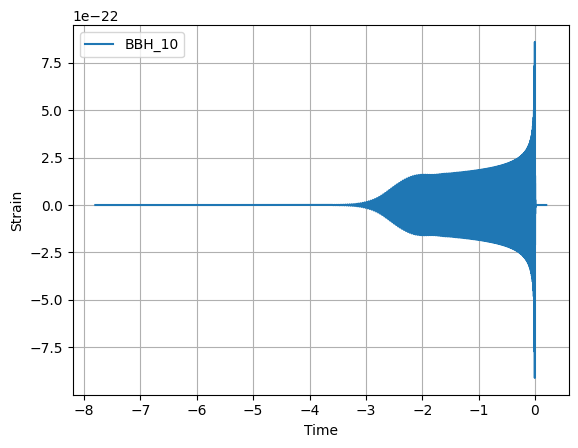

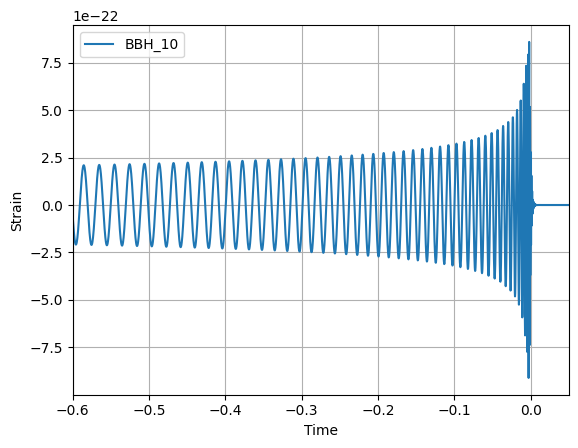

fp=0.5494252193754385, fc=-0.5320202660769405


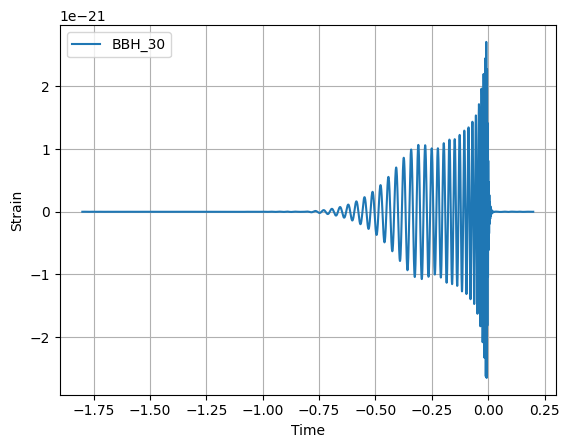

In [3]:
def gen_waveform(model,m1,m2,s1z,s2z,time,l):
    
    from pycbc.detector import Detector
    from pycbc.waveform import get_td_waveform


    distance_1 = 200
    ra = 1.7
    dec = 1.7
    pol = 0.2
    inclination_1 = 0




    # We can calcualate the antenna pattern for Hanford at
    # the specific sky location
    d = Detector("H1")

    # We get back the fp and fc antenna pattern weights.
    fp, fc = d.antenna_pattern(ra, dec, pol, time)
    print("fp={}, fc={}".format(fp, fc))

    # These factors allow us to project a signal into what the detector would observe
    # IMRPhenomPv2
    # Generate the waveform for the BNS merger
    hp_1, hc_1 = get_td_waveform(approximant=model,
                             mass1=m1, mass2=m2,spin1z=s1z,spin2z=s2z,
                             distance=distance_1, inclination=inclination_1,
                             delta_t=1.0/4096, f_lower=30)

    ## Apply the factors to get the detector frame strain
    ht_1 = fp * hp_1 + fc * hc_1
    
    
    pp.plot(ht_1.sample_times, ht_1, label=l)
    pp.legend()
    pp.ylabel('Strain')
    pp.xlabel('Time')
    pp.grid()
    pp.show()
    
    
    
    return ht_1

# generating BNS signal

h1_bbh_10 = gen_waveform('IMRPhenomPv2',10,10,0.6,0.6,0.0,"BBH_10")

pp.plot(h1_bbh_10.sample_times, h1_bbh_10, label='BBH_10')
pp.legend()
pp.xlim(-0.6,0.05)
pp.ylabel('Strain')
pp.xlabel('Time')
pp.grid()
pp.show()




h1_bbh_30 = gen_waveform('IMRPhenomPv2',30,30,0.8,0.8,0.0,"BBH_30")



# Combining the Signals

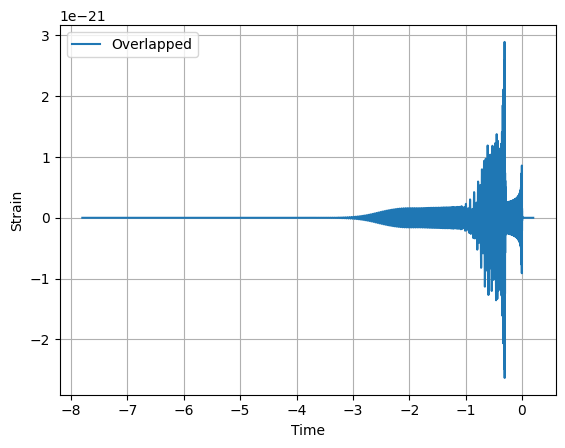

In [4]:
def overlap(ht_1,ht_2,buffer):
    
    #Equal lengths of signals
    ht_2.resize(len(ht_1))
    
    #Shifting the merger time
    ht_2=ht_2.cyclic_time_shift(ht_2.end_time - buffer)
    
    #Equating the start time of both signals
    ht_2.start_time = ht_1.start_time
    
    #Combining the signals
    ht_total = ht_1 + ht_2

    #Ploting the signals
    pp.plot(ht_total.sample_times, ht_total, label='Overlapped')
    pp.legend()
    pp.ylabel('Strain')
    pp.xlabel('Time')
    pp.grid()
    pp.show()
    
    return ht_total,ht_2

ht_total,h1_bbh_30 = overlap(h1_bbh_10,h1_bbh_30,0.5)


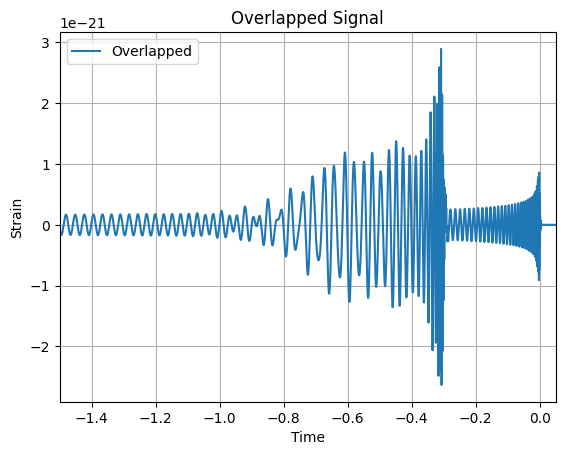

In [5]:
pp.plot(ht_total.sample_times, ht_total, label='Overlapped')
pp.xlim(-1.5,0.05)
#pp.ylim(-0.5*(10**-21),0.5*(10**-21))
pp.legend()
pp.ylabel('Strain')
pp.xlabel('Time')
pp.title('Overlapped Signal')
pp.grid()
pp.show()

# Injecting Strain into noise

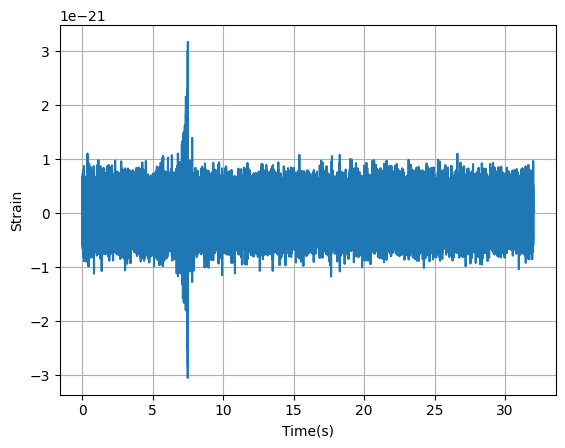

In [6]:
def inject(ht_total,ts):
    
    #Resizing the signal
    ht_total.resize(len(ts)) 
    
    #Equating the start time
    ht_total.start_time = ts.start_time
    
    #Injecting signal into noise
    ts = ts.add_into(ht_total) 
    
    #plotting the result
    pp.plot(ts.sample_times, ts)
    pp.xlabel('Time(s)')
    pp.ylabel('Strain')
    pp.grid()
    pp.show()
    
    return ts 

ts1 = inject(ht_total,noise)

# Calculating the PSD

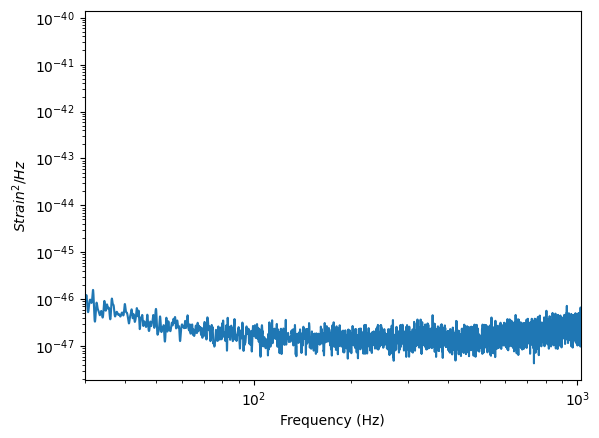

In [7]:
def psd_data(conditioned):

    from pycbc.psd import interpolate, inverse_spectrum_truncation
    # Estimate the power spectral density

    # We use 4 second samples of our time series in Welch method.
    psd = conditioned.psd(4)

    # Now that we have the psd we need to interpolate it to match our data
    # and then limit the filter length of 1 / PSD. After this, we can
    # directly use this PSD to filter the data in a controlled manner

    psd = interpolate(psd, conditioned.delta_f)

    # 1/PSD will now act as a filter with an effective length of 4 seconds
    # Since the data has been highpassed above 30 Hz, and will have low values
    # below this we need to informat the function to not include frequencies
    # below this frequency. 
    psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                      low_frequency_cutoff=30)

    pp.loglog(psd.sample_frequencies, psd)
    pp.ylabel('$Strain^2 / Hz$')
    pp.xlabel('Frequency (Hz)')
    pp.xlim(30, 1024)
    
    return psd

psd1 = psd_data(ts1)
    

# Generating the Template

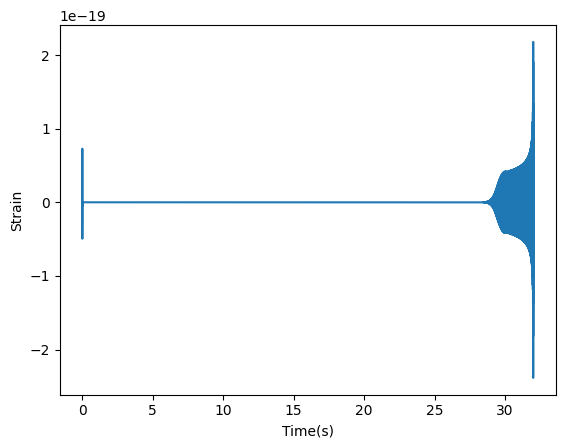

In [8]:
def gen_template(model,m1,m2,s1z,s2z,conditioned):
    
    
    
    hp, hc = get_td_waveform(approximant=model,
                     mass1=m1,
                     mass2=m2,spin1z=s1z,spin2z=s2z,
                     delta_t=conditioned.delta_t,
                     f_lower=30)
    
    #Resizing the template to match data
    hp.resize(len(conditioned))
    
    #Time shift 
    template = hp.cyclic_time_shift(hp.start_time)
    
    #plotting
    pp.plot(template.sample_times,template)
    pp.xlabel('Time(s)')
    pp.ylabel('Strain')
    pp.show()
    
    return template


template = gen_template('IMRPhenomPv2',10,10,0.6,0.6,ts1)

# Generating SNR time series

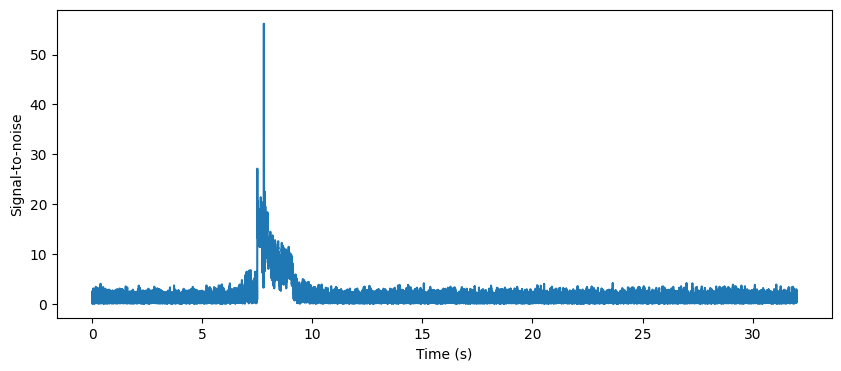

We found a signal at 7.7998046875s with SNR 56.19074387754037


In [9]:
def gen_SNR(template,conditioned,psd):
    from pycbc.filter import matched_filter
    import numpy

    snr = matched_filter(template, conditioned,
                         psd=psd, low_frequency_cutoff=30)



    # The `matched_filter` function actually returns a 'complex' SNR.
    # What that means is that the real portion correponds to the SNR
    # associated with directly filtering the template with the data.
    # The imaginary portion corresponds to filtering with a template that
    # is 90 degrees out of phase. Since the phase of a signal may be 
    # anything, we choose to maximize over the phase of the signal.


    pp.figure(figsize=[10, 4])
    pp.plot(snr.sample_times, abs(snr))
    pp.ylabel('Signal-to-noise')
    pp.xlabel('Time (s)')
    pp.show()

    peak = abs(snr).numpy().argmax()
    snrp = snr[peak]
    time = snr.sample_times[peak]

    print("We found a signal at {}s with SNR {}".format(time, 
                                                        abs(snrp)))
    return snr

snr1 = gen_SNR(template,ts1,psd1)

### Subtracting BBH Signal from data 

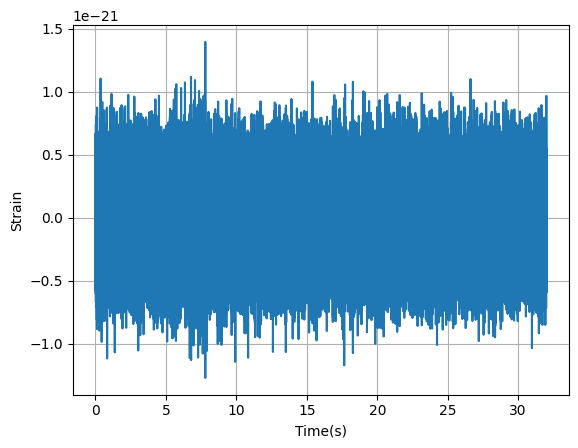

In [10]:
h1_bbh_30.resize(len(ts1))
h1_bbh_30.start_time = ts1.start_time
ts2 = ts1 - h1_bbh_30
pp.plot(ts2.sample_times, ts2)
pp.xlabel('Time(s)')
pp.ylabel('Strain')
pp.grid()
pp.show()

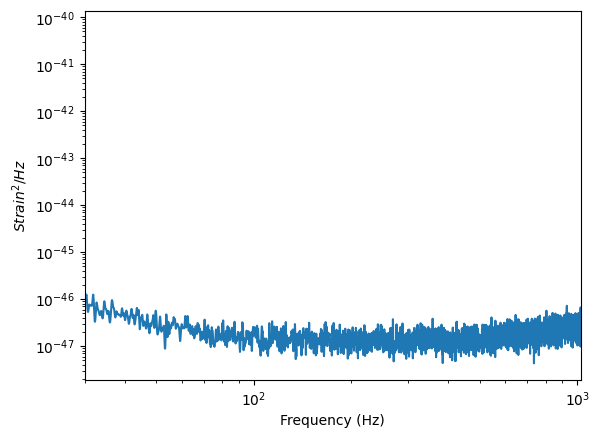

In [11]:
psd2 = psd_data(ts2) #Calculating psd for case 2

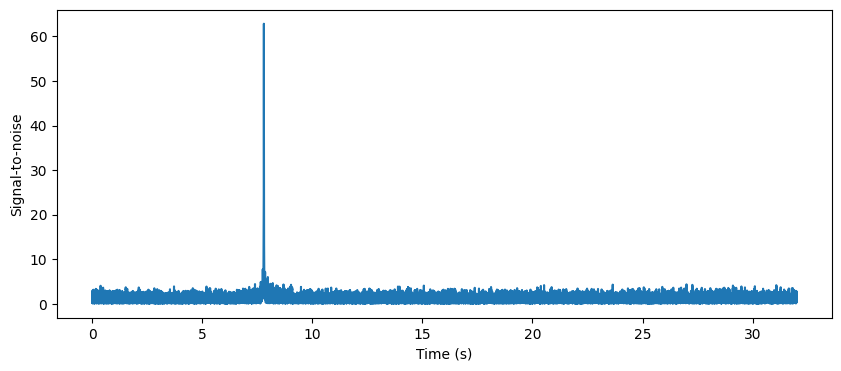

We found a signal at 7.800048828125s with SNR 62.86691099382972


In [12]:
snr2 = gen_SNR(template,ts2,psd2) #calculating snr for case 2